In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import gcm
from sklearn.linear_model import RidgeCV

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# <ins>What are Causal Graphs?</ins>

x

# <ins>How can they be used to build actionable business cases?</ins>

x

# <ins>Call centre case study</ins>

x

In [2]:
# Create node lookup for channels
node_lookup = {0: 'Call waiting time',
    1: 'Call abandoned', 
    2: 'Reported problems',                   
    3: 'Discount sent',
    4: 'Churn'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # Call waiting time -> Call abandoned
graph_actual[0, 4] = 1.0 # Call waiting time -> Churn
graph_actual[1, 2] = 1.0 # Call abandoned -> Reported problems
graph_actual[1, 4] = 1.0 # Call abandoned -> Churn
graph_actual[2, 3] = 1.0 # Reported problems -> Discount sent
graph_actual[2, 4] = 1.0 # Reported problems -> Churn
graph_actual[3, 4] = 1.0 # Discount sent -> Churn
     
graph_actual

array([[0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [3]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(8,8))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=8000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

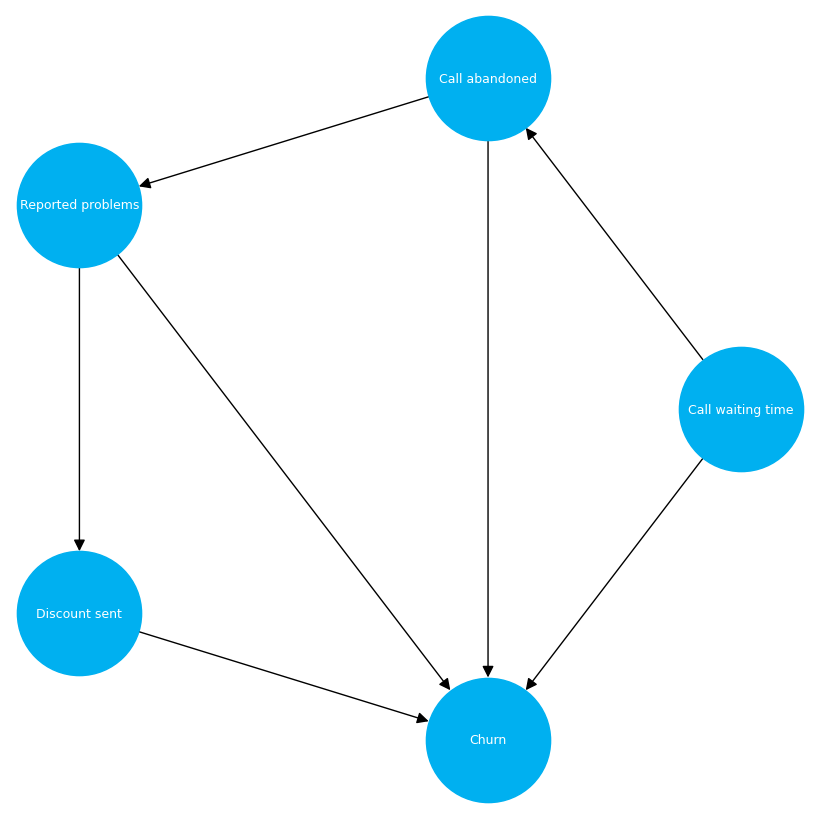

In [4]:
plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

# <ins>Data generating process</ins>

x

In [5]:
def data_generator(max_call_waiting, inbound_calls, call_reduction):
    '''
     A data generating function which has the flexibility to reduce the value of node 0 (Call waiting time) - this enables us to calculate ground truth counterfactuals

    Args:
        max_call_waiting (int): Maximum call waiting time in seconds
        inbound_calls (int): Total number of inbound calls (observations in data)
        call_reduction (float): Reduction to apply to call waiting time

    Returns:
        DataFrame: Generated data
    '''
    
    df = pd.DataFrame(columns=node_lookup.values())

    df[node_lookup[0]] = np.random.randint(low=10, high=max_call_waiting, size=(inbound_calls)) * (call_reduction) # Call waiting time
    df[node_lookup[1]] = (df[node_lookup[0]] * 0.5) + np.random.normal(loc=0, scale=30, size=inbound_calls) # Call abandoned
    df[node_lookup[2]] = (df[node_lookup[1]] * 0.6) + np.random.normal(loc=0, scale=20, size=inbound_calls) # Reported problems
    df[node_lookup[3]] = (df[node_lookup[2]] * 0.7) + np.random.normal(loc=0, scale=10, size=inbound_calls) # Discount sent
    df[node_lookup[4]] = (0.10 * df[node_lookup[0]] ) + (0.30 * df[node_lookup[1]]) + (0.15 * df[node_lookup[2]]) + (-0.20 * df[node_lookup[3]]) # Churn

    return df

In [6]:
# Generate data
np.random.seed(999)
df = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=1.00)
df

,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,458.0,218.923240,121.234995,96.316889,110.398843
1,358.0,218.513414,143.757874,108.029500,101.311805
2,491.0,242.098338,119.087699,72.209693,125.150718
3,235.0,136.290298,102.007038,79.287775,63.830590
4,485.0,253.320383,189.289900,138.441886,125.201223
...,...,...,...,...,...
9995,376.0,180.831950,142.115812,88.487472,95.469462
9996,25.0,-4.072559,-42.958523,-24.789112,-0.207724
9997,420.0,243.859226,179.390097,129.777104,116.110862
9998,292.0,199.579546,101.303381,62.522177,91.764936


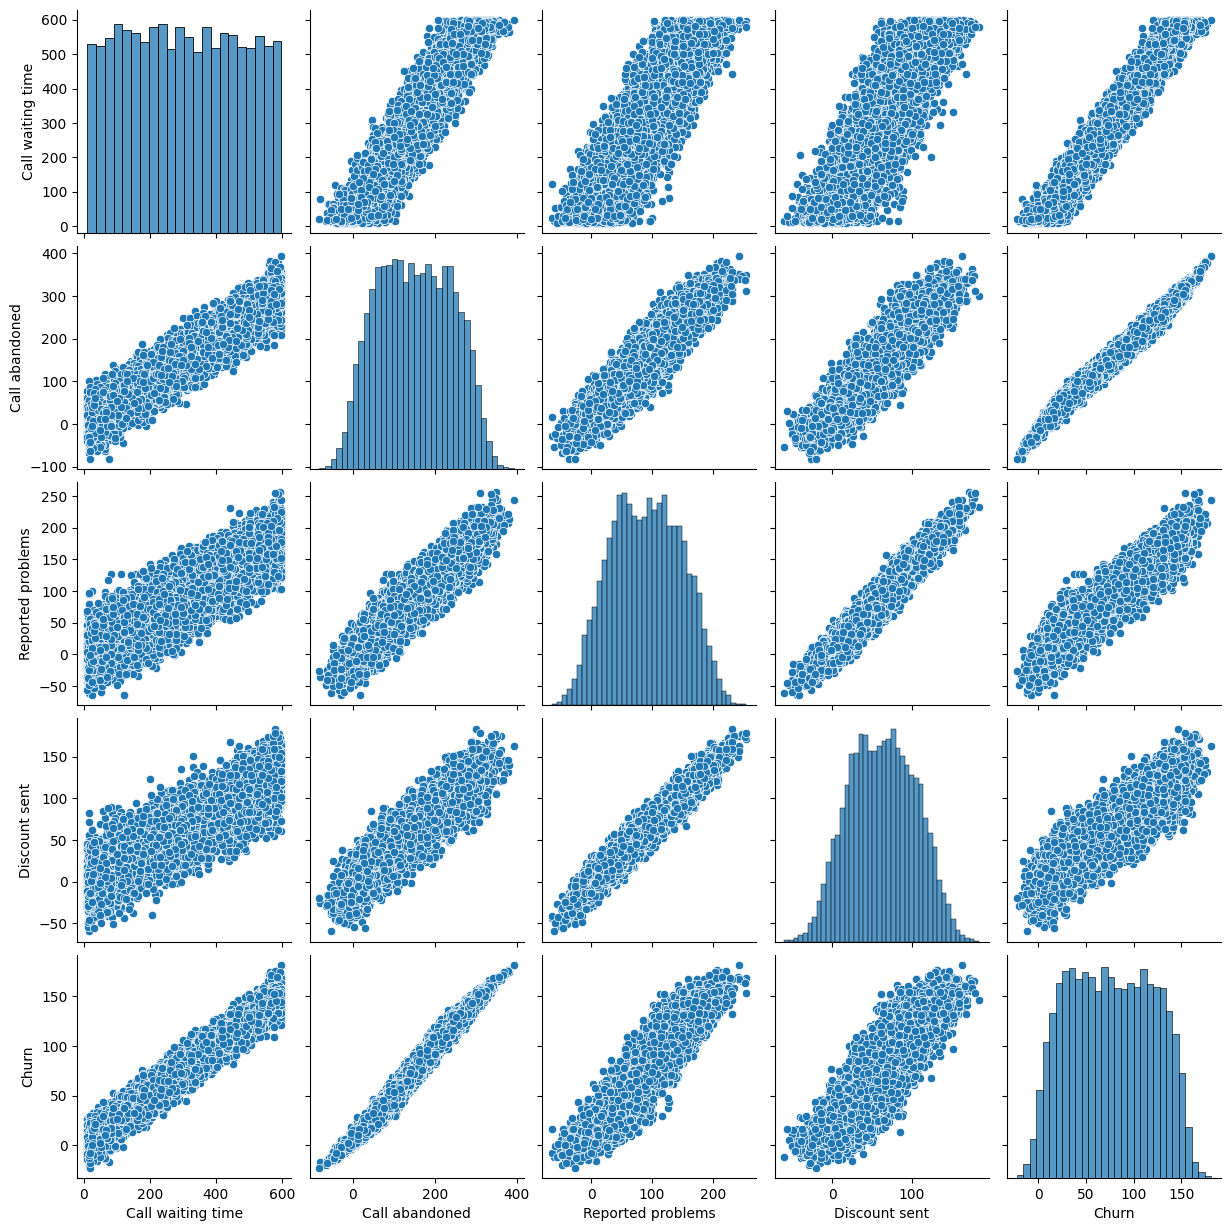

In [7]:
sns.pairplot(df)

# <ins>Training the graph</ins>

x

In [8]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)

# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)
causal_model.set_causal_mechanism('Call waiting time', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('Call abandoned', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
causal_model.set_causal_mechanism('Reported problems', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
causal_model.set_causal_mechanism('Discount sent', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
causal_model.set_causal_mechanism('Churn', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
gcm.fit(causal_model, df)

Fitting causal mechanism of node Churn: 100%|██████████| 5/5 [00:00<00:00, 197.11it/s]   


Test permutations of given graph: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


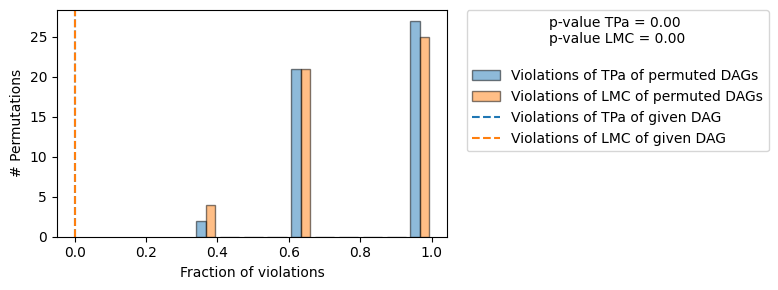

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [9]:
# Check model fit statistics
print(gcm.evaluate_causal_model(causal_model, df))

# <ins>Linear regression comparion</ins>

x

In [10]:
# Ridge regression
y = df['Churn'].copy()
X = df.iloc[:, 0:-1].copy()
model = RidgeCV()
model = model.fit(X, y)
y_pred = model.predict(X)

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_}')
# Ground truth[0.10 0.30 0.15 -0.20]

Intercept: 0.00048180367134875723
Coefficient: [ 0.09999885  0.29999943  0.14999963 -0.20000021]


# <ins>Estimating counterfactuals</ins>

x

In [11]:
call_reduction = 1 - 0.20

In [12]:
# Generate counterfactual data
np.random.seed(999)
df_cf = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=call_reduction)
df_cf

,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,366.4,173.123240,93.754995,77.080889,87.224043
1,286.4,182.713414,122.277874,92.993500,83.197005
2,392.8,192.998338,89.627699,51.587693,100.306118
3,188.0,112.790298,87.907038,69.417775,51.939590
4,388.0,204.820383,160.189900,118.071886,100.660223
...,...,...,...,...,...
9995,300.8,143.231950,119.555812,72.695472,76.443862
9996,20.0,-6.572559,-44.458523,-25.839112,-1.472724
9997,336.0,201.859226,154.190097,112.137104,94.858862
9998,233.6,170.379546,83.783381,50.258177,76.989736


In [13]:
# What would have happened if we had decreased the Call waiting time by 20%
ground_truth = round((df['Churn'].sum() - df_cf['Churn'].sum()) / df['Churn'].sum(), 2)

# Causal graph counterfactual
df_counterfactual = gcm.counterfactual_samples(causal_model, {'Call waiting time': lambda x: x*call_reduction}, observed_data=df)
causal_graph = round((df['Churn'].sum() - df_counterfactual['Churn'].sum()) / (df['Churn'].sum()), 3)

# Linear regression counterfactual
linear_regression = round((df['Call waiting time'].sum() * 1.0 * model.coef_[0] - df['Call waiting time'].sum() * call_reduction * model.coef_[0]) / (df['Churn'].sum()), 3)

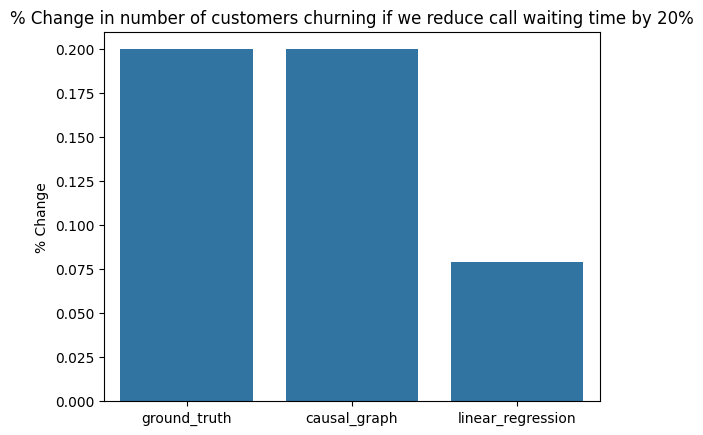

In [14]:
categories = ['ground_truth', 'causal_graph', 'linear_regression']
sns.barplot(x=categories, y=[ground_truth, causal_graph, linear_regression])
plt.ylabel('% Change')
plt.title('% Change in number of customers churning if we reduce call waiting time by 20%')
plt.show()

# <ins>Future considerations</ins>

x